In [ ]:
#Steven Zajac-Descôteaux

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score, precision_recall_curve,plot_roc_curve,plot_precision_recall_curve

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [3]:
#Model 1
titanic = sns.load_dataset('titanic')
#titanic.info()

#Drop values are missing for most or duplicates. 
titanic.drop(['deck','class','alive','embark_town','who'],axis=1,inplace=True) 

titanic.dropna(inplace=True) #Drop NaN AFTER dropping deck because lots of deck missing
titanic.reset_index(inplace=True,drop=True)#Reset and drop old index

#Get dummies for sex and droo
titanic['male'] = pd.get_dummies(titanic['sex'],drop_first=True)
titanic[['class_2','class_3']] = pd.get_dummies(titanic['pclass'],drop_first=True)
titanic[['embarked_Q','embarked_S']] = pd.get_dummies(titanic['embarked'],drop_first=True)

#Drop emabrked
titanic.drop(['embarked','sex','pclass'],inplace=True,axis=1)

#Convert bool to int (binary)
titanic.alone = titanic.alone.astype(int)
titanic.adult_male = titanic.adult_male.astype(int)

y = titanic.survived 

X = titanic.drop('survived',axis=1)
X = sm.add_constant(X)

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     87.54
Date:                Sat, 13 Feb 2021   Prob (F-statistic):          1.45e-123
Time:                        09:14:10   Log-Likelihood:                -293.74
No. Observations:                 712   AIC:                             611.5
Df Residuals:                     700   BIC:                             666.3
Df Model:                          11                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1999      0.067     17.820      0.000       1.068       1.332
age           -0.0033      0.001     -2.902      0.004      -0.006      -0.001
sibsp         -0.1216      0.020     -5.972      0.000      -0.161      -0.082
parch         -0.0568      0.022     -2.602      0.009      -0.100      -0.014
fare           0.0004      0.000      1.058      0.290      -0.000       0.001
adult_male    -0.5450      0.073     -7.510      0.000      -0.687      -0.403
alone         -0.1030      0.043     -2.387      0.017      -0.188      -0.018
male          -0.0090      0.068     -0.131      0.896      -0.143       0.125
class_2       -0.1631      0.047     -3.478      0.001      -0.255      -0.071
class_3       -0.3186      0.052     -6.101      0.000      -0.421      -0.216
embarked_Q    -0.1201      0.081     -1.486      0.137      -0.278       0.038
embarked_S    -0.0494      0.042     -1.187      0.235      -0.131       0.032
==============================================================================
Omnibus:                       34.297   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.481
Skew:                           0.524   Prob(JB):                     4.40e-09
Kurtosis:                       3.446   Cond. No.                         498.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [18]:
#Sklearn
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

log_model = LogisticRegression(random_state=0)

log_model.fit(X_scaled,y)

log_model.coef_

array([[ 0.        , -0.34259526, -0.55824667, -0.24566481,  0.13263286,
        -1.40856975, -0.17858768, -0.09356377, -0.47648681, -1.0819531 ,
        -0.17014653, -0.13983957]])

In [19]:
log_mod = sm.Logit(y,X).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.417785
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           11
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.3809
Time:                        15:13:36   Log-Likelihood:                -297.46
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.004e-71
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2603      0.559      7.627      0.000       3.165       5.355
age           -0.0241      0.009     -2.686      0.007      -0.042      -0.007
sibsp         -0.6301      0.157     -4.023      0.000      -0.937      -0.323
parch         -0.2980      0.150     -1.992      0.046      -0.591      -0.005
fare           0.0023      0.003      0.851      0.395      -0.003       0.008
adult_male    -3.0613      0.552     -5.550      0.000      -4.142      -1.980
alone         -0.3706      0.320     -1.158      0.247      -0.998       0.257
male          -0.0406      0.507     -0.080      0.936      -1.035       0.954
class_2       -1.1850      0.344     -3.448      0.001      -1.859      -0.511
class_3       -2.2523      0.360     -6.265      0.000      -2.957      -1.548
embarked_Q    -0.8847      0.604     -1.466      0.143      -2.068       0.298
embarked_S    -0.3254      0.287     -1.134      0.257      -0.888       0.237
==============================================================================
"""

In [21]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

lin_model = LinearRegression().fit(scaled_X_train, y_train)
lin_y_pred = lin_model.predict(X_test)

log_model = LogisticRegression().fit(scaled_X_train, y_train)
log_y_pred = log_model.predict(X_test)

In [18]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#lin_model = LinearRegression().fit(X_train, y_train)
#lin_y_pred = lin_model.predict(X_test)

#log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
#log_y_pred = log_model.predict(X_test)

#Using StandardScaler reduces scores below

In [19]:
f = lambda x: 1 if x > 0.5 else 0
f_vec = np.vectorize(f)

In [22]:
print(classification_report(y_test, f_vec(lin_y_pred)))
print(classification_report(y_test, log_y_pred))

              precision    recall  f1-score   support

           0       0.66      0.94      0.77       125
           1       0.78      0.33      0.46        89

    accuracy                           0.68       214
   macro avg       0.72      0.63      0.62       214
weighted avg       0.71      0.68      0.64       214

              precision    recall  f1-score   support

           0       0.67      0.91      0.78       125
           1       0.76      0.38      0.51        89

    accuracy                           0.69       214
   macro avg       0.72      0.65      0.64       214
weighted avg       0.71      0.69      0.66       214



In [48]:
accuracy_score(y_test, log_y_pred) #Log model. Won't work for lin

0.7757009345794392

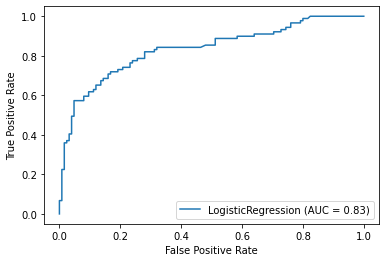

In [49]:
plot_roc_curve(log_model,X_test,y_test);

#At least it's not facing downawrd

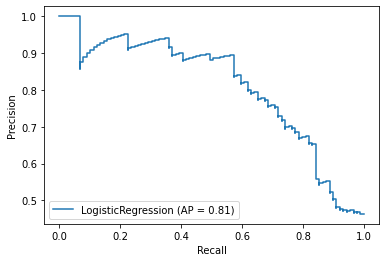

In [50]:
plot_precision_recall_curve(log_model,X_test,y_test);

In [51]:
#Overall looks likes there's not much diffrence between the two.
#Linear model might be performing slightly better. a fraction of a point

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [7]:
t_size = 10_000

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=t_size, random_state=42)

scaler = StandardScaler()
#Didn't use PolyFeatures because it would overwhelm my mac. Did use standard scaler
# because get a better score than without 

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test) #No fit on X_test prevent data leakage

log_model = LogisticRegression(solver='lbfgs',max_iter=1000) #Increase max_iter to prevent error

In [8]:
log_model.fit(scaled_X_train,y_train)

LogisticRegression(max_iter=1000)

In [9]:
y_pred = log_model.predict(scaled_X_test)

In [16]:
#accuracy_score(y_test,y_pred) or log_model.score(scaled_X_test,y_test)
print(f'Accuracy of Logistic Regression on test set: {accuracy_score(y_test,y_pred)}')

Accuracy of Logistic Regression on test set: 0.9161


In [17]:
confusion_matrix(y_test,y_pred)

array([[ 940,    0,    8,    1,    1,   10,   12,    4,    6,    1],
       [   0, 1122,    5,    5,    1,    4,    1,    3,    8,    3],
       [   7,   13,  866,   14,    6,    9,   16,   11,   21,    4],
       [   3,    8,   23,  921,    2,   30,    4,   15,   14,   14],
       [   4,    1,    6,    5,  836,    4,   10,    6,    6,   28],
       [  10,    6,    6,   37,    8,  812,   15,    2,   31,   10],
       [   6,    6,   12,    1,    8,   14,  909,    2,    3,    0],
       [   1,    2,   21,    3,   12,    4,    1,  990,    1,   20],
       [   7,   21,   13,   35,    4,   34,   12,    6,  822,   15],
       [   5,    7,    4,   10,   25,    4,    0,   29,    9,  943]])

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       983
           1       0.95      0.97      0.96      1152
           2       0.90      0.90      0.90       967
           3       0.89      0.89      0.89      1034
           4       0.93      0.92      0.92       906
           5       0.88      0.87      0.87       937
           6       0.93      0.95      0.94       961
           7       0.93      0.94      0.93      1055
           8       0.89      0.85      0.87       969
           9       0.91      0.91      0.91      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [22]:
fish = pd.read_csv('data/fish.csv')

In [23]:
fish.head()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1


In [101]:
#fish.FISH_COUNT.value_counts() #Lots of zeros

In [34]:
#ZeroInflatedPoisson method:
X = sm.add_constant(fish.drop('FISH_COUNT',axis=1))

y = fish.FISH_COUNT

In [39]:
dist_poisson = sm.ZeroInflatedPoisson(y,X).fit()
dist_poisson.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Sat, 06 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         12:18:35   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

In [126]:
#Two-Stage Modelling:

X = sm.add_constant(fish.drop('FISH_COUNT',axis=1))
y = fish.FISH_COUNT

#Stage 1:

est1 = sm.Logit((y>0),X).fit()
#est1.summary()

# Prep Stage 2:
X = pd.DataFrame(sm.add_constant(X))
X['stage1'] = est1.predict(X)


#Stage 2:
est2 = sm.Poisson(y,X).fit()
#sm.graphics.plot_fit(est2,5,vlines=False)
est2.summary()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6
Optimization terminated successfully.
         Current function value: 3.145454
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      244
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.5228
Time:                        13:55:16   Log-Likelihood:                -786.36
converged:                       True   LL-Null:                       -1647.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1977      0.266    -12.018      0.000      -3.719      -2.676
LIVE_BAIT      1.9649      0.250      7.858      0.000       1.475       2.455
CAMPER         1.0589      0.119      8.895      0.000       0.826       1.292
PERSONS        1.4232      0.112     12.689      0.000       1.203       1.643
CHILDREN      -2.4239      0.231    -10.512      0.000      -2.876      -1.972
stage1        -2.1432      0.642     -3.339      0.001      -3.401      -0.885
==============================================================================
"""

### Interpretation:

* From my understanding is that all of the coefs are significant in this model. For example, CHILDREN has a negative impact as to how many or if any fish are being caught. While LIVE_BAIT has a positive impact. Same goes to PERSONS and CAMPER, but to a lesser extend. But these coefs do not inform us directly as to how many more fish will be caught under certain conditions. It gives us an idea of how each feature will overall impact the response variable

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [143]:
df = pd.read_csv('data/telco_churn.csv')

In [144]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [685]:
df = pd.read_csv('data/telco_churn.csv')
#Yes or No only

y_n = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']

df[y_n] = df[y_n].eq('Yes').mul(1)

#Yes or No or No int
y_n_n  = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingMovies','StreamingTV']

df[y_n_n] = df[y_n_n].replace(('No internet service','No','Yes'),(np.nan,0,1))

#Drop rows where people simply don't have internet service since we are looking at streaming
null_ = (df[df['StreamingTV'].isnull()==True].index) #Need to drop NaN Values
df.drop(df.index[null_],inplace=True)

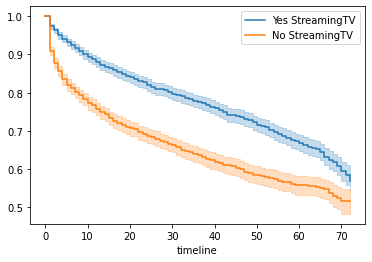

In [686]:
#With dropped rows to make graph look like above

from lifelines import KaplanMeierFitter

T = df.tenure
E = df.Churn

kmf = KaplanMeierFitter()
kmf.fit(T,E)
groups = df.StreamingTV
ix = (groups == 0)
kmf.fit(T[~ix],E[~ix],label='Yes StreamingTV')
ax = kmf.plot_survival_function()
kmf.fit(T[ix],E[ix],label='No StreamingTV')
ax = kmf.plot_survival_function(ax=ax)

In [687]:
df = pd.read_csv('data/telco_churn.csv')

y_n = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn','OnlineSecurity','OnlineBackup',
       'DeviceProtection','TechSupport','StreamingMovies']

df[y_n] = df[y_n].eq('Yes').mul(1)

#Drop rows where people simply don't have internet service since we are looking at streaming
null_ = (df[df['StreamingTV'].isnull()==True].index) #Need to drop NaN Values
df.drop(df.index[null_],inplace=True)

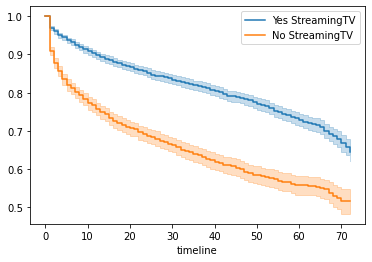

In [688]:
# Without dropping the rows. Either have StreamingTV or No (including no internet)
T = df.tenure
E = df.Churn

kmf = KaplanMeierFitter()
kmf.fit(T,E)
groups = df.StreamingTV
ix = (groups == 'No')
kmf.fit(T[~ix],E[~ix],label='Yes StreamingTV')
ax = kmf.plot_survival_function()
kmf.fit(T[ix],E[ix],label='No StreamingTV')
ax = kmf.plot_survival_function(ax=ax)

In [734]:
df = pd.read_csv('data/telco_churn.csv')

y_n = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn','OnlineSecurity','OnlineBackup',
       'DeviceProtection','TechSupport','StreamingMovies','StreamingTV']
df[y_n] = df[y_n].eq('Yes').mul(1)

df['Male'] = df.gender.eq('Male').mul(1) #Male col
df['MultipleLines'] = df['MultipleLines'].eq('Yes').mul(1)
#Either they have mutliple lines or just no lines 

to_drop = ['InternetService','gender','Contract','PaymentMethod'] #Drop gender 
#Error in my code when try to use these features. 

dummies = ['InternetService','Contract','PaymentMethod']
dumb_df = pd.get_dummies(df[dummies],drop_first=True) #Get dummies-not sure if better or not to. 

df.drop(to_drop,axis=1,inplace=True) #Drop cols

df = df.join(dumb_df) #Join--if was using dummies

df.drop('customerID',axis=1,inplace=True) #Drop irrelevant col

df.TotalCharges = pd.to_numeric(df.TotalCharges,errors='coerce') #Convert to numeric

#df.TotalCharges.fillna(value=df.TotalCharges.median(),inplace=True) #Gives error for Weibull

In [735]:
d_ind = (df[df['TotalCharges'].isnull()==True].index) #Need to drop NaN Values
df.drop(df.index[d_ind],inplace=True)

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2021-02-06 22:41:49 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.04       0.06            -0.08             0.15                 0.93                 1.16
Partner                                -0.18       0.84       0.06            -0.29            -0.07                 0.75                 0.93
Dependents                             -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
PhoneService                            0.83       2.29       0.47            -0.10             1.76                 0.90                 5.80
MultipleLines                           0.09       1.09       0.13            -0.16             0.33                 0.85                 1.40
OnlineSecurity                         -0.21       0.81       0.13            -0.47             0.05                 0.62                 1.05
OnlineBackup                           -0.06       0.95       0.13            -0.31             0.19                 0.74                 1.21
DeviceProtection                        0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
TechSupport                            -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.19
StreamingTV                             0.28       1.32       0.24            -0.18             0.74                 0.83                 2.10
StreamingMovies                         0.29       1.33       0.24            -0.18             0.75                 0.84                 2.11
PaperlessBilling                        0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
MonthlyCharges                          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Male                                   -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
InternetService_Fiber optic             1.02       2.77       0.58            -0.12             2.15                 0.89                 8.59
InternetService_No                     -2.34       0.10       0.60            -3.51            -1.17                 0.03                 0.31
Contract_One year                      -1.27       0.28       0.10            -1.46            -1.07                 0.23                 0.34
Contract_Two year                      -3.70       0.02       0.20            -4.10            -3.31                 0.02                 0.04
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
PaymentMethod_Mailed check              0.51       1.67       0.09             0.34             0.68                 1.40                 1.98

                                           z      p   -log2(p)
covariate                                                     
SeniorCitizen                           0.61   0.54       0.88
Partner      

None


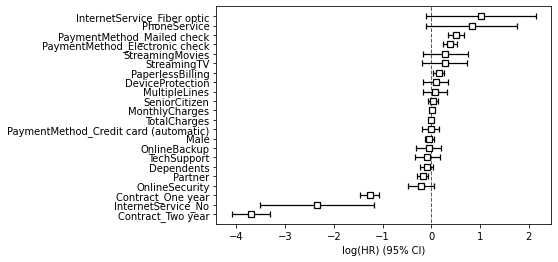

In [736]:
from lifelines import CoxPHFitter,WeibullAFTFitter

cph = CoxPHFitter()
cph.fit(df,'tenure',event_col='Churn')
print(cph.print_summary())
cph.plot()

<lifelines.WeibullAFTFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7032
number of events observed = 1869
           log-likelihood = -8142.88
         time fit was run = 2021-02-06 22:41:52 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Contract_One year                       0.53       1.70       0.07             0.40             0.66                 1.49                 1.93
        Contract_Two year                       1.20       3.33       0.12             0.97             1.44                 2.63                 4.22
        Dependents                              0.10       1.11       0.05             0.01             0.20                 1.01                 1.22
        DeviceProtection                       -0.00       1.00       0.09            -0.18             0.17                 0.84                 1.18
        InternetService_Fiber optic            -0.63       0.53       0.41            -1.42             0.17                 0.24                 1.18
        InternetService_No                      1.10       2.99       0.41             0.28             1.91                 1.33                 6.74
        Male                                    0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
        MonthlyCharges                         -0.00       1.00       0.02            -0.04             0.03                 0.97                 1.03
        MultipleLines                          -0.00       1.00       0.09            -0.17             0.17                 0.84                 1.19
        OnlineBackup                            0.05       1.05       0.09            -0.13             0.22                 0.88                 1.25
        OnlineSecurity                          0.20       1.23       0.09             0.02             0.39                 1.02                 1.47
        PaperlessBilling                       -0.11       0.89       0.04            -0.19            -0.03                 0.83                 0.97
        Partner                                 0.11       1.12       0.04             0.04             0.19                 1.04                 1.21
        PaymentMethod_Credit card (automatic)   0.04       1.04       0.06            -0.08             0.17                 0.92                 1.18
        PaymentMethod_Electronic check         -0.26       0.77       0.05            -0.36            -0.16                 0.70                 0.85
        PaymentMethod_Mailed check             -0.27       0.77       0.06            -0.39            -0.15                 0.68                 0.86
        PhoneService                           -0.19       0.83       0.33            -0.84             0.46                 0.43                 1.58
        SeniorCitizen                          -0.03       0.97       0.04            -0.10             0.05                 0.90                 1.05
        StreamingMovies                        -0.13       0.88       0.17            -0.46             0.19                 0.63                 1.21
        StreamingTV                            -0.15       0.86       0.17            -0.47             0.18                 0.62                 1.19
        TechSupport                             0.15       1.16       0.09            -0.04             0.33                 0.96                 1.39
        TotalCharges                            0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Intercept                          

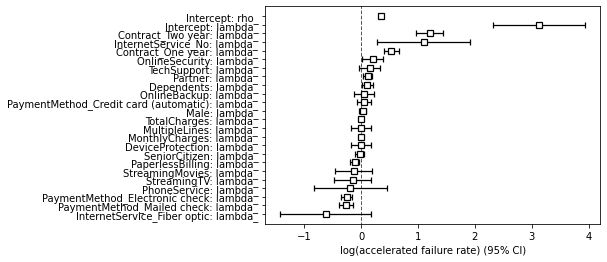

In [737]:
wft = WeibullAFTFitter()
wft.fit(df,'tenure',event_col='Churn')
wft.print_summary()
wft.plot()

In [730]:
df = pd.read_csv('data/telco_churn.csv')

df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [731]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [732]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [733]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64